# Import libraries


In [ ]:
import nltk 
nltk.download('punkt')
import urllib3
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


# Corpus pre-processing

In [ ]:
corpus = "https://github.com/imsouza/spell-checker/blob/main/corpus/data.txt?raw=true"

http = urllib3.PoolManager()
response = http.request('GET', corpus)
data = response.data.decode('utf-8')

In [ ]:
data = data[:1000000]

## Tokenization

In [ ]:
def split_words(tokens):
  wordlist = []
  for token in tokens:
      if token.isalpha():
          wordlist.append(token)
  return wordlist

In [ ]:
tokens = nltk.tokenize.word_tokenize(data)
wordlist = split_words(tokens)

## Normalization

In [ ]:
def normalization(wordlist):
  normalized_wordlist = []
  for word in wordlist:
      normalized_wordlist.append(word.lower())
  return normalized_wordlist

In [ ]:
normalized_wordlist = set(normalization(wordlist))
len(normalized_wordlist)

18840

# Spell Checker algorithm

In [ ]:
def insert_letters(slices):
  new_words = []
  alphabet = 'abcdefghijklmnopqrstuvwxyzàáâãèéêìíîòóôõùúûç'
  for left, right in slices:
      for letter in alphabet:
          new_words.append(left + letter + right)
  return new_words

In [ ]:
def swap_letters(slices):
  new_words = []
  alphabet = 'abcdefghijklmnopqrstuvwxyzàáâãèéêìíîòóôõùúûç'
  for left, right in slices:
      for letter in alphabet:
          new_words.append(left + letter + right[1:])
  return new_words

In [ ]:
def reverse_letters(slices):
  new_words = []
  alphabet = 'abcdefghijklmnopqrstuvwxyzàáâãèéêìíîòóôõùúûç'
  for left, right in slices:
      if len(right) > 1:
        new_words.append(left + right[1] + right[0] + right[2:])
  return new_words

In [ ]:
def delete_letters(slice):
  new_words = []
  for left, right in slice:
      new_words.append(left + right[1:])
  return new_words

In [ ]:
def word_generator(word):
  slices = []
  for i in range(len(word)+1):
      slices.append((word[:i],word[i:]))
  generated_words = insert_letters(slices)
  generated_words += delete_letters(slices)
  generated_words += swap_letters(slices)
  generated_words += reverse_letters(slices)
  return generated_words

In [ ]:
def upgrade_word_generator(generated_words):
  new_words = []

  for word in generated_words:
    new_words += word_generator(word)
  return new_words

In [ ]:
def get_metrics(normalized_wordlist):
  frequency = nltk.FreqDist(normalized_wordlist)
  total_words = len(normalized_wordlist)
  return frequency, total_words

In [ ]:
metrics = get_metrics(normalized_wordlist)
frequency, total_words = metrics[0], metrics[1]

In [ ]:
def probability(generated_word):
  return frequency[generated_word] / total_words

In [ ]:
def spell_checker(word):
  generated_words = word_generator(word)
  correct_word = max(generated_words, key=probability)
  return correct_word

In [ ]:
def upgrade_spell_checker(word):
  generated_words = word_generator(word)
  updated_generated_word = upgrade_word_generator(generated_words)
  all_words = set(generated_words + updated_generated_word)
  selected_words = [word]

  for word in all_words:
    if word in normalized_wordlist:
      selected_words.append(word)
  correct_word = max(selected_words, key=probability)
  return correct_word

# Evaluate algorithm

In [ ]:
def split_test_data(file):
  test_wordlist = []
  f = open(file, "r")
  for line in f:
      correct, wrong = line.split()
      test_wordlist.append((correct, wrong))
  f.close()
  return test_wordlist

In [ ]:
data_tests = split_test_data("test.txt")
data_tests

In [ ]:
def evaluate(tests, vocabulary, upgrade=False):
  """
  Returns the hit rate (in %), unknown hate (in %) and the total number of words
  """
  words_size = len(tests)
  hit = 0
  unknown = 0

  corrected_word = []

  for correct, wrong in tests:
    if (upgrade):
      corrected_word = upgrade_spell_checker(wrong)
    else:
      corrected_word = spell_checker(wrong)
    unknown += (correct not in vocabulary)

    if corrected_word == correct:
      hit += 1
      
  return round(hit*100/words_size, 2), round(unknown*100/words_size, 2), words_size

## Evaluate using only the distance of one typing error from the wrong word


In [ ]:
one_distance = evaluate(data_tests, set(normalized_wordlist), upgrade=False)
one_distance

(61.08, 8.65, 185)

## Evaluate using only the distance of two typing errors from the wrong word

In [ ]:
two_distances = evaluate(data_tests, set(normalized_wordlist), upgrade=True)
two_distances

(17.3, 8.65, 185)

## Plot results

In [ ]:
dict_1 = {'hit_rate':one_distance[0], 'unknown_rate':one_distance[1], 'total_test_words':one_distance[2]}
dict_2 = {'hit_rate':two_distances[0], 'unknown_rate':two_distances[1], 'total_test_words':two_distances[2]}

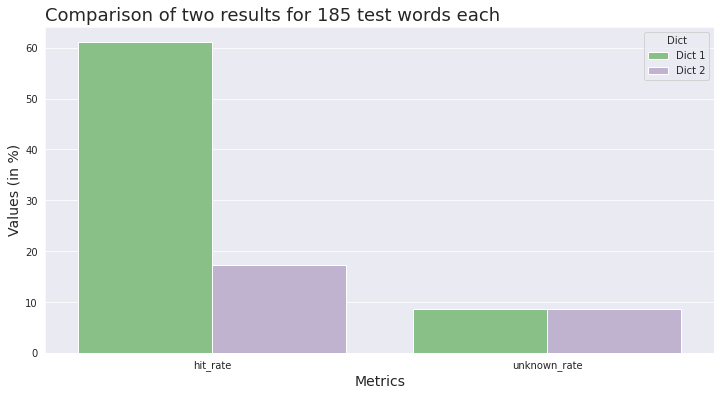

In [ ]:
plt.figure(figsize=(12,6))
sns.set_palette('Accent')
sns.set_style('darkgrid')

df1 = pd.DataFrame(dict_1, index=[0]).assign(Dict='Dict 1')
df2 = pd.DataFrame(dict_2, index=[0]).assign(Dict='Dict 2')

df_concat = pd.concat([df1, df2], ignore_index=True)
df_melt = df_concat.melt(var_name='Metric', value_name='Value', value_vars=['hit_rate', 'unknown_rate'], id_vars=['Dict'])

sns.barplot(x='Metric', y='Value', hue='Dict', data=df_melt)

plt.xlabel('Metrics', fontsize=14)
plt.ylabel('Values (in %)', fontsize=14)
plt.title('Comparison of two results for 185 test words each', loc='left',fontsize=18)

plt.show()